## Grokking Hacking 5 

Ok let me try to get my head around the frequency restricted model

In [1]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
branch = "main"

# Install dependencies
try:
    import transformer_lens
except:
    %pip install transformer_lens==2.11.0

# Get root directory, handling 3 different cases: (1) Colab, (2) notebook not in ARENA repo, (3) notebook in ARENA repo
root = (
    "/content"
    if IN_COLAB
    else "/root"
    if repo not in os.getcwd()
    else str(next(p for p in Path.cwd().parents if p.name == repo))
)

if Path(root).exists() and not Path(f"{root}/{chapter}").exists():
    if not IN_COLAB:
        !sudo apt-get install unzip
        %pip install jupyter ipython --upgrade

    if not os.path.exists(f"{root}/{chapter}"):
        !wget -P {root} https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/{branch}.zip
        !unzip {root}/{branch}.zip '{repo}-{branch}/{chapter}/exercises/*' -d {root}
        !mv {root}/{repo}-{branch}/{chapter} {root}/{chapter}
        !rm {root}/{branch}.zip
        !rmdir {root}/{repo}-{branch}

if f"{root}/{chapter}/exercises" not in sys.path:
    sys.path.append(f"{root}/{chapter}/exercises")

os.chdir(f"{root}/{chapter}/exercises")

In [2]:
import os
import sys
from functools import partial
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn.functional as F
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt
from ipywidgets import interact

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
section = "part52_grokking_and_modular_arithmetic"
root_dir = next(p for p in Path.cwd().parents if (p / chapter).exists())
exercises_dir = root_dir / chapter / "exercises"
section_dir = exercises_dir / section

grokking_root = section_dir / "Grokking"
saved_runs_root = grokking_root / "saved_runs"

import part52_grokking_and_modular_arithmetic.tests as tests
import part52_grokking_and_modular_arithmetic.utils as utils

device = t.device("cuda" if t.cuda.is_available() else "cpu")

t.set_grad_enabled(False)

MAIN = __name__ == "__main__"

In [3]:
p = 113

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

model = HookedTransformer(cfg)

In [4]:
REPO_ID = "callummcdougall/grokking_full_run_data"
FILENAME = "full_run_data.pth"

local_dir = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

full_run_data = t.load(local_dir, weights_only=True)
state_dict = full_run_data["state_dicts"][400]

model = utils.load_in_state_dict(model, state_dict)

In [5]:
# Get all data and labels, and cache activations
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([utils.target_fn(i, j) for i, j, _ in all_data]).to(device)
original_logits, cache = model.run_with_cache(all_data)

# Final position only, also remove the logits for `=`
original_logits = original_logits[:, -1, :-1]

# Get cross entropy loss
original_loss = utils.cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item():.3e}")

Original loss: 2.412e-07


In [6]:
for k in cache:
    print(k, cache[k].shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [7]:
original_logits.shape

torch.Size([12769, 113])

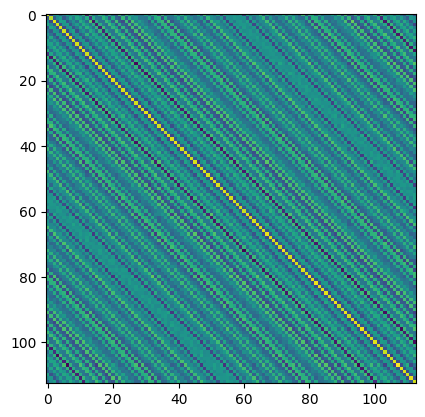

In [8]:
plt.imshow(original_logits[:p, :].detach().cpu().numpy())

- Hmm have I tried any scattter plot action on the logits actually?
- Hmm does that make sense tho? The yellow line is the answer->that's fun.

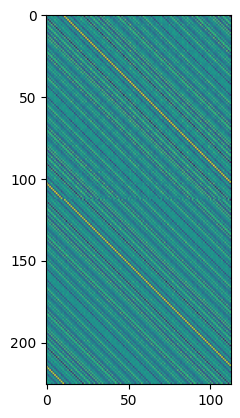

In [9]:
plt.imshow(original_logits[10*p:12*p, :].detach().cpu().numpy())